<a href="https://colab.research.google.com/github/wlsgud623/vaccine_tweet_analysis/blob/main/VaccineHesistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3

import transformers
from transformers import BertTokenizer
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 754 kB 4.9 MB/s 
     |████████████████████████████████| 1.2 MB 42.1 MB/s 
     |████████████████████████████████| 895 kB 66.6 MB/s 
     |████████████████████████████████| 3.0 MB 38.4 MB/s 


In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jinhyeoungbae","key":"dc42a77071a666d47d2e97f076322dfb"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d kaushiksuresh147/covidvaccine-tweets
! kaggle datasets download -d gpreda/all-covid19-vaccines-tweets

 92% 49.0M/53.1M [00:00<00:00, 114MB/s] 
100% 53.1M/53.1M [00:00<00:00, 153MB/s]
 80% 24.0M/29.9M [00:00<00:00, 55.8MB/s]
100% 29.9M/29.9M [00:00<00:00, 119MB/s] 


In [5]:
!unzip all-covid19-vaccines-tweets.zip
!unzip covidvaccine-tweets.zip

Archive:  all-covid19-vaccines-tweets.zip
  inflating: vaccination_all_tweets.csv  
Archive:  covidvaccine-tweets.zip
  inflating: covidvaccine.csv        


In [6]:
first_vaccine_data = pd.read_csv("/content/covidvaccine.csv", nrows = 50000)
second_vaccine_data = pd.read_csv("/content/vaccination_all_tweets.csv", nrows = 50000)
data_column = ['user_name', 'user_description','user_location','user_followers','text']

first_vaccine_data = first_vaccine_data[data_column]
second_vaccine_data = second_vaccine_data[data_column]

import re

def con(x):
  return ' '.join(re.sub("(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",str(x)).split())
    
first_vaccine_data['text']=first_vaccine_data['text'].apply(con)
second_vaccine_data['text']=second_vaccine_data['text'].apply(con)

analysis_data = pd.concat([first_vaccine_data,second_vaccine_data], ignore_index=True)
analysis_data['text'].dropna()
analysis_data.drop_duplicates()
analysis_data.head()

,user_name,user_description,user_location,user_followers,text
0,MyNewsNE,MyNewsNE a dedicated multi-lingual media house...,Assam,64.0,Australia to Manufacture Covid 19 Vaccine and ...
1,Shubham Gupta,I will tell about all experiences of my life f...,NaN,1.0,Australia is doing very good
2,Journal of Infectiology,Journal of Infectiology (ISSN 2689-9981) is ac...,NaN,143.0,Deaths due to COVID 19 in Affected Countries R...
3,Zane,Fresher than you.,NaN,29.0,Subhashree Stay safe di amp da
4,Ann-Maree O’Connor,Retired university administrator. Melburnian b...,"Adelaide, South Australia",83.0,This is what passes for leadership in our coun...


In [7]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [8]:
sentiment_data  = pd.read_csv("/gdrive/My Drive/sentiment.csv", header=None)
del sentiment_data[0]
sentiment_data.rename(columns={1:'label'}, inplace=True)
sentiment_data.head()

,label
0,2
1,2
2,1
3,2
4,1


In [9]:
print(analysis_data.shape)
print(sentiment_data.shape)

(100000, 5)
(100000, 1)


In [10]:
positive_tweet = pd.DataFrame(columns=['user_name', 'user_description','user_location','user_followers','text'])
neutral_tweet = pd.DataFrame(columns=['user_name', 'user_description','user_location','user_followers','text'])
negative_tweet = pd.DataFrame(columns=['user_name', 'user_description','user_location','user_followers','text'])

for index, values in analysis_data.iterrows():
  if sentiment_data['label'][index] == 0:
    negative_tweet = negative_tweet.append(values, ignore_index=True)

  elif sentiment_data['label'][index] == 1:
    neutral_tweet = neutral_tweet.append(values, ignore_index=True)

  elif sentiment_data['label'][index] == 2:
    positive_tweet = positive_tweet.append(values, ignore_index=True)


In [11]:
#positive_tweet = positive_tweet.reset_index(drop=True)
#positive_tweet.head()
#neutral_tweet = neutral_tweet.drop(index)
#neutral_tweet = neutral_tweet.reset_index(drop=True)
#neutral_tweet.head()
#negative_tweet = negative_tweet.drop(index)
#negative_tweet = negative_tweet.reset_index(drop=True)
negative_tweet.head()

,user_name,user_description,user_location,user_followers,text
0,Dr. Joseph Santoro,"Neuro PhD, #Innovator, #Technologist, #Startup...","Washington, DC 20009",19091.0,Most countries without the ability to make loc...
1,Deepak Sakpal,Full time Parent | Photography | Equity Tradin...,Mumbai - India,68.0,phase 3 trials begin in next 7 10 days what do...
2,Gettodoor,Along with the latest updates of surrounding a...,NaN,49.0,You must tell yourself no matter how hard it i...
3,@TheCupIsNice,"All of the Wrestling Companys,🏀,⚾,🏈,👊MMA and ⚽...","Las Vegas, NV",55.0,your gonna go down as the worst President of a...
4,Ⓜanoj Kumar Sharma,Assistant Chief Content Editor at E TV Bharat,India,470.0,The National Sports Awards likely to be held v...


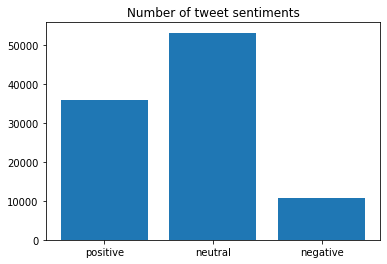

In [12]:
tweet_number =[len(positive_tweet),len(neutral_tweet),len(negative_tweet)]
tweet_label = ['positive','neutral','negative']

plt.bar(tweet_label, tweet_number)
plt.title('Number of tweet sentiments')
plt.show()

Tweet analysis by follwers

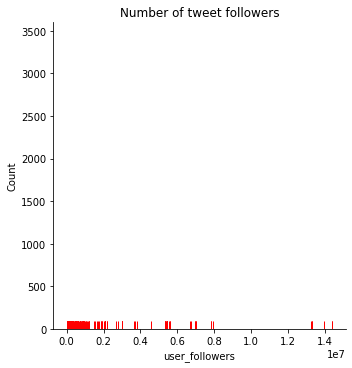

In [13]:
%matplotlib inline
sns.displot(negative_tweet['user_followers'], color='red', rug=True)
plt.title('Number of tweet followers')
plt.show()

Tweet analysis by location

In [94]:
positive_loc = positive_tweet['user_location'].str.split(',',expand=True)
negative_loc = negative_tweet['user_location'].str.split(',',expand=True)

postive_loc=positive_loc.rename(columns={0:'fst_loc',1:'snd_loc'})
negative_loc=negative_loc.rename(columns={0:'fst_loc',1:'snd_loc'})

postive_loc['snd_loc'] = postive_loc['snd_loc'].str.strip()
negative_loc['snd_loc'] = negative_loc['snd_loc'].str.strip()

state_fix = {'Ontario': 'Canada','United Arab Emirates': 'UAE','TX': 'USA','NY': 'USA'
                  ,'FL': 'USA','England': 'UK','Watford': 'UK','GA': 'USA','IL': 'USA'
                  ,'Alberta': 'Canada','WA': 'USA','NC': 'USA','British Columbia': 'Canada','MA': 'USA','ON':'Canada'
            ,'OH':'USA','MO':'USA','AZ':'USA','NJ':'USA','CA':'USA','DC':'USA','AB':'USA','PA':'USA','SC':'USA'
            ,'VA':'USA','TN':'USA','New York':'USA','Dubai':'UAE','CO':'USA', 'Gujarat':'India', 'darkest Victoria':'UK'}

postive_loc = postive_loc.replace({"snd_loc": state_fix}) 
negative_loc = negative_loc.replace({"snd_loc": state_fix})

In [100]:
#sns.countplot(postive_loc["snd_loc"][:100])
positive_loc.value_counts()[:20]


0                               1              2          3      4      5                   6         
My book is available on Amazon   Google books   Appstore   Nook   Kobo   Barnes and Nobles   Scribd...    1
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2313 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2337 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/u

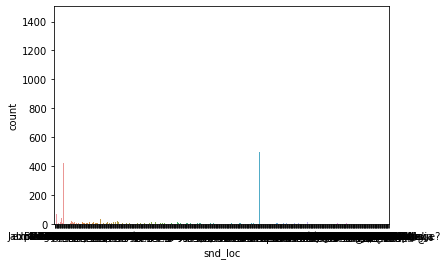

In [101]:
sns.countplot(negative_loc["snd_loc"])
plt.show()

Tweet Topic

In [ ]:
!pip install yake

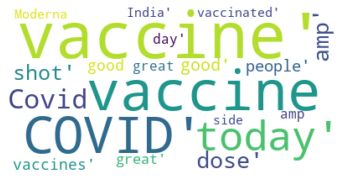

In [65]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import yake

kw_extracter = yake.KeywordExtractor(lan='eng', n=2, dedupLim=0.9, top=3, features=None)
positive_keyword = ''

for p in positive_tweet['text']:
  keywords = kw_extracter.extract_keywords(p)
  for key in keywords:
    positive_keyword = positive_keyword + str(key)

positive_wordcloud = WordCloud(collocations=False, background_color='white',mode='RGBA', max_words=20).generate(positive_keyword)
plt.figure()
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

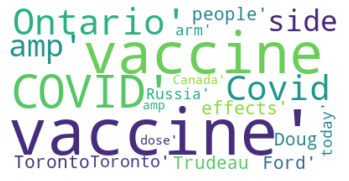

In [66]:
negative_keyword = ''

for n in negative_tweet['text']:
  keywords = kw_extracter.extract_keywords(n)
  for key in keywords:
    negative_keyword = negative_keyword + str(key)

negative_wordcloud = WordCloud(collocations=False, background_color='white',mode='RGBA', max_words=20).generate(negative_keyword)
plt.figure()
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Reason of Hesistant
**Reference paper** : Psychological characteristics and the mediating role of the 5C Model in explaining students’ COVID-19 vaccination intention, Wismans A, Thurik R, Baptista R, Dejardin M, Janssen F

5C Model : Confidence, Calculation, Complacency, Constraints, Collective Responsibility

Get associative words from https://www.visualthesaurus.com/


In [23]:
five_C_model = ['Confidence', 'Calculation', 'Complacency', 'Constraints','Collective Responsibility']
# Confidence : 백신 효능과 안전성, 이를 제공하는 보건 서비스, 그리고 정부의 배포 결정에 대한 신뢰 여부
# Calculation : 질병 자체를 건강에 심각한 위험으로 생각하는지 여부
# Complacency : 손익을 따지기 위해 광범위한 정보 검색에 참여하는지 여부
# Constraints : 백신을 접하기가 얼마나 쉬운지 여부
# Colllective Responsibility : 스스로 예방 접종을 통해 타인을 보호하려는 의지가 있는지

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

C-19 Vaccine Realated

In [27]:
# 백신의 효과 인지
perceived_effectiveness = ['effect', 'set up', 'outcome','useless', 'futile', 'vain']
pe = []
for key in perceived_effectiveness:
  tokens = tokenizer.tokenize(key)
  for token in tokens:
    pe.append(token)
# 백신의 위험성 인지
perceived_risk_vaccine = ['aftereffect', 'fear', 'risk', 'dangerous']
pv = []
for key in perceived_risk_vaccine:
  tokens = tokenizer.tokenize(key)
  for token in tokens:
    pv.append(token)
# 가족, 사회적 규범
normative_beliefs = ['family', 'friend', 'relative', 'social', 'religion', 'chruch']
nb = []
for key in normative_beliefs:
  tokens = tokenizer.tokenize(key)
  for token in tokens:
    nb.append(token)

# 접종을 통해 얻을 수 있는 이익
perceived_benefits = ['benefit', 'cost', 'expensive', 'price']
pb = []
for key in perceived_benefits:
  tokens = tokenizer.tokenize(key)
  for token in tokens:
    pb.append(token)


C-19 Related

In [29]:
# covid-19의 위험성 인지
perceived_risk_c19 = ['symptom', 'terror', 'worry', 'unease']
pr = []
for key in perceived_risk_vaccine:
  tokens = tokenizer.tokenize(key)
  for token in tokens:
    pr.append(token)
# 감염된 경험
c19_infection = ['ill', 'suffer', 'taken']
ci = []
for key in c19_infection:
  tokens = tokenizer.tokenize(key)
  for token in tokens:
    ci.append(token)

Personality

In [31]:
# 낙관론
optimism = ['optimism', 'positive', 'termperament', 'hope', 'disposition']
opt = []
for key in optimism:
  tokens = tokenizer.tokenize(key)
  for token in tokens:
    opt.append(token)
# 충동 정도
impulsivity = ['impulse', 'impel', 'hotheaded', 'madcap', 'impetuos', 'driving', 'capricious', 'early', 'fast']
imp = []
for key in impulsivity:
  tokens = tokenizer.tokenize(key)
  for token in tokens:
    imp.append(token)
# 이타주의
altruism = ['altruism', 'unselfishness', 'philanthropy', 'selflessness']
alt = []
for key in altruism:
  tokens = tokenizer.tokenize(key)
  for token in tokens:
    alt.append(token)
# 소속감
need_to_belong = ['belong', 'our', 'nation', 'happy','pertain', 'inhere', 'appertain']
ntb = []
for key in need_to_belong:
  tokens = tokenizer.tokenize(key)
  for token in tokens:
    ntb.append(token)

General

In [32]:
# 정부, 기관에 대한 신뢰
trust_in_goverment = ['goverment','president', 'leader', 'political', 'distrust', 'concern', 'doubt', 'suspect']
tig = []
for key in trust_in_goverment:
  tokens = tokenizer.tokenize(key)
  for token in tokens:
    tig.append(token)

# Score measurement

In [33]:
def check_word_in_list(target, keywords):
  NUM_WORD = 0
  for word in keywords:
    NUM_WORD = NUM_WORD + target.count(word)
  
  return NUM_WORD

In [61]:
def Five_C_Score(text):
  # 텍스트를 bert tokenizer로 분리
  tokenized_text = tokenizer.tokenize(text)
  
  score_pe = check_word_in_list(tokenized_text, perceived_effectiveness)
  score_prv = check_word_in_list(tokenized_text, perceived_risk_vaccine)
  score_nb = check_word_in_list(tokenized_text, normative_beliefs)
  score_pb = check_word_in_list(tokenized_text, perceived_benefits)

  score_rc = check_word_in_list(tokenized_text, perceived_risk_c19)
  score_ci = check_word_in_list(tokenized_text, c19_infection)

  score_opt = check_word_in_list(tokenized_text, optimism)
  score_imp = check_word_in_list(tokenized_text, impulsivity)
  score_alt = check_word_in_list(tokenized_text, altruism)
  score_ntb = check_word_in_list(tokenized_text, need_to_belong)

  score_tig = check_word_in_list(tokenized_text, trust_in_goverment)

  C_score = [0,0,0,0,0]

  C_score[0] = score_pe + score_prv + score_nb + score_opt - score_tig
  C_score[1] = score_prv + score_rc + score_opt + score_imp 
  C_score[2] = score_nb + score_rc + score_ci
  C_score[3] = score_opt + score_imp + score_alt
  C_score[4] = -score_pb + score_rc + score_alt + score_ntb

  
  c_max = C_score.index(max(C_score))

  if C_score == [0,0,0,0,0]:
    c_max = None
  total_score = C_score[0] - C_score[1] - C_score[2] - C_score[3] + C_score[4]

  return total_score,c_max

In [62]:
best_reason = []
score_list = []

for text in negative_tweet['text']:
  c_score,c_index = Five_C_Score(text)
  best_reason.append(c_index)
  score_list.append(c_score)

In [103]:
print(negative_tweet['text'][15])
print(best_reason[15])

Thanks 2 our fearless leader we have now officially bought 800 million doses of a highly dangerous
0


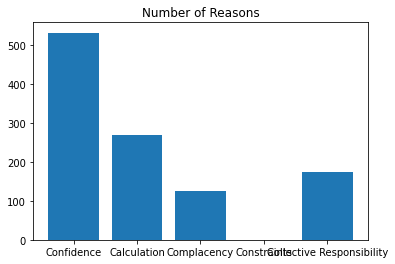

In [98]:
reason_list = [best_reason.count(0),best_reason.count(1),best_reason.count(2),best_reason.count(3),best_reason.count(4)]
plt.bar(five_C_model, reason_list)
plt.title('Number of Reasons')
plt.show()